# Preamble


In [29]:
from utils.dataset import SegmentaionDataset
from utils.models.unet import UnetScratch
from importlib import reload
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import segmentation_models_pytorch as smp
from tqdm import tqdm
import cv2
from PIL import Image
import pandas as pd
import numpy as np
from torchviz import make_dot
import torchvision.transforms.v2 as TF
import torch
import torch.nn as nn
import torch.optim as optim

# Data Augmentation
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

# get data/time with desired format
from datetime import datetime
time_format = "%Y.%m.%d@%H-%M-%S"

# torchvision

# keep numpy use to a min
# as we store our torch.Tensors to GPU Vram but numpy in RAM (it only supports CPU)

# to have a progress bar

# To use pretrained segmentation models (implement in PyTorch)

# visualization
# uncomment if wan't to globally aloow sns to handle plot style
# it adds unwanted style (i.e., grid) to .imshow()
# so better to use it a context manager to style only what I want
# >>> with sns.axes_style('darkgrid'):
# >>>     plt.imshow(...)
# sns.set_theme(
#     context="notebook",
#     style="darkgrid",
#     palette="deep",
#     font="sans-serif",
#     font_scale=1,
#     color_codes=True,
#     rc={'axes.grid': False},
# )

# OS/File/Path management


# load my custom Classes/Functions/etc.


# from utils import (
#     load_checkpoint,
#     save_checkpoint,
#     get_loaders,
#     check_accuracy,
#     save_pred_as_imgs
# )

## Set up GPU use


In [2]:
print("PyTorch ver:", torch.__version__)

# set max_split_size_mb to avoid GPU VRAM (out of MEM error)
# Could use terminal/shell instead:
# for linux: export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
# for winows: set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

# force pytorch to use GPU
# use "model.to(device)" later on to force a model use Cuda GPU
print("Can I use GPU?", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used for calculation (CPU\Cuda):", device)

PyTorch ver: 2.0.1+cu118
Can I use GPU? True
Device used for calculation (CPU\Cuda): cuda:0


## Set Hyperparameters


In [59]:
hyper_params = {
    "device": device,
    "lr": 1e-4,
    # due to limited Mem I values larger than 4 raise GPU MEM Error
    "batch_size": 16,
    "num_classes": 1,
    "epochs": 10,
    "num_workers": 2,
    # for UNet Vanila (the one from smp lib) the H/W must be a factor of 32
    "image_height": 384,
    "image_width": 640,
    "num_classes": 1,
    "pin_mem": True,
    "load_model": False,
    "load_model_path": os.path.join("models"),
    # define path(s)
    "train_img_dir": os.path.join("data", "traincrop", "img"),
    "train_mask_dir": os.path.join("data", "traincrop", "mask"),
    "val_img_dir": os.path.join("data", "valcrop", "img"),
    "val_mask_dir": os.path.join("data", "valcrop", "mask"),
    "test_img_dir": os.path.join("data", "testcrop", "img"),
    "test_mask_dir": os.path.join("data", "testcrop", "mask"),
}

# device = device
# lr = 1e-4
# # due to limited Mem I values larger than 4 raise GPU MEM Error
# batch_size = 16
# epochs = 10
# num_workers = 2
# # for UNet the H/W must be a factor of 32
# image_height = 384
# image_width = 640
# num_classes = 1
# pin_mem = True
# load_model = False
# load_model_path = os.path.join('models')

# # define path(s)
# train_img_dir = os.path.join("data", "traincrop", "img")
# train_mask_dir = os.path.join("data", "traincrop", "mask")
# val_img_dir = os.path.join("data", "valcrop", "img")
# val_mask_dir = os.path.join("data", "valcrop", "mask")
# test_img_dir = os.path.join("data", "testcrop", "img")
# test_mask_dir = os.path.join("data", "testcrop", "mask")

# Create Dataset


In [4]:
from utils.dataset import get_loaders, SegmentaionDataset
import utils.dataset
reload(utils.dataset)


# Define a set of augmentations (resize, rescale, augmentation, etc.)
train_transform = A.Compose(
    [
        A.Resize(height=hyper_params['image_height'],
                 width=hyper_params['image_width']),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        # A.RandomRotate90(p=1),  # Use only when the img_height==img_width
        # A.Transpose(p=1),  # Use only when the img_height==img_width
        # A.RandomBrightnessContrast(p=0.8),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2,
                      hue=0.2, always_apply=False, p=0.8),
        A.ImageCompression(quality_lower=99, quality_upper=100, p=0.5),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10,
                   b_shift_limit=10, p=0.5),
        # this is for z-scoring
        # TODO: add pretrained model's own preprocess layer
        A.Normalize(mean=[0.0, 0.0, 0, 0], std=[
                    1.0, 1.0, 1.0], max_pixel_value=255.0),
        # ToTensorV2(),
    ],
    # is_check_shapes=False,  # risky
)

# we don't want TTA, just some resize, normalization, etc.
val_transform = A.Compose(
    [
        A.Resize(height=hyper_params['image_height'],
                 width=hyper_params['image_width']),
        # TODO: add pretrained model's own preprocess layer
        A.Normalize(mean=[0.0, 0.0, 0, 0], std=[
                    1.0, 1.0, 1.0], max_pixel_value=255.0),
        # ToTensorV2(),
    ],
    # is_check_shapes=False,  # risky
)

# create our datasets (with our custom Class)
train_ds = SegmentaionDataset(
    image_dir=hyper_params['train_img_dir'],
    mask_dir=hyper_params['train_mask_dir'],
    transform=train_transform,
    mask_suffix="",
    # subset=[0, 10],
)
val_ds = SegmentaionDataset(
    image_dir=hyper_params['val_img_dir'],
    mask_dir=hyper_params['val_mask_dir'],
    transform=val_transform,
    mask_suffix="",
    # subset=[0, 5],
)
test_ds = SegmentaionDataset(
    image_dir=hyper_params['test_img_dir'],
    mask_dir=hyper_params['test_mask_dir'],
    transform=val_transform,
    mask_suffix="",
    subset=[0, 5],
)

# Create Datatset by data loaders
train_loader, val_loader, test_loader = get_loaders(
    train_ds,
    val_ds,
    test_ds,
    hyper_params['batch_size'],
    hyper_params['num_workers'],
    hyper_params['pin_mem'],
)

In [5]:
# (Fast) Using Dataset's __len__ magic method (always work)
print("# train images:", len(train_ds))
print("# val images:", len(val_ds))
print("# test images:", len(test_ds))

# (Slow) Using Data Loader (is a hit or miss)
# print('# train images:', sum(len(batch) for batch in train_loader))
# print('# val images:', sum(len(batch) for batch in val_loader))

# this outputs wrong nume (why??)
# it's not even the #imgs in mini_batch??
# print(len(train_loader))

# train images: 1896
# val images: 348
# test images: 5


## Visualize Dataset(s)


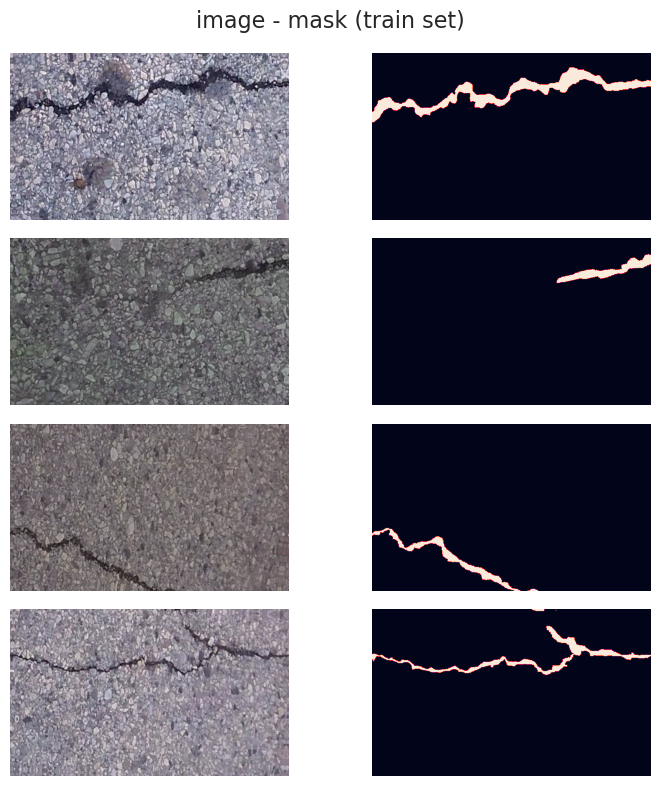

In [6]:
img_mask_iter = ((img, mask) for img, mask in train_ds)

plt.figure(figsize=(8, 8))
for i in range(0, 4 * 2, 2):
    img, mask = next(img_mask_iter)
    plt.subplot(4, 2, i + 1)
    plt.imshow(np.moveaxis(img, 0, -1))
    plt.axis("off")
    plt.subplot(4, 2, i + 2)
    plt.imshow(np.moveaxis(mask, 0, -1))
    plt.axis("off")

plt.suptitle("image - mask (train set)", fontsize=16)
plt.tight_layout()
plt.show()

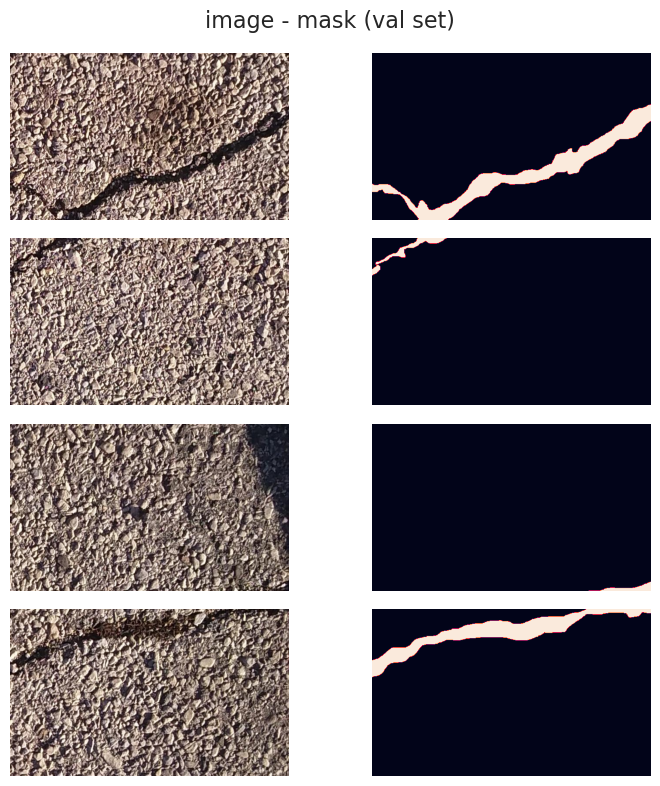

In [52]:
img_mask_iter = ((img, mask) for img, mask in val_ds)

plt.figure(figsize=(8, 8))
for i in range(0, 8, 2):
    img, mask = next(img_mask_iter)
    plt.subplot(4, 2, i + 1)
    plt.imshow(np.moveaxis(img, 0, -1))
    plt.axis("off")
    plt.subplot(4, 2, i + 2)
    plt.imshow(np.moveaxis(mask, 0, -1))
    plt.axis("off")

plt.suptitle("image - mask (val set)", fontsize=16)
plt.tight_layout()
plt.show()

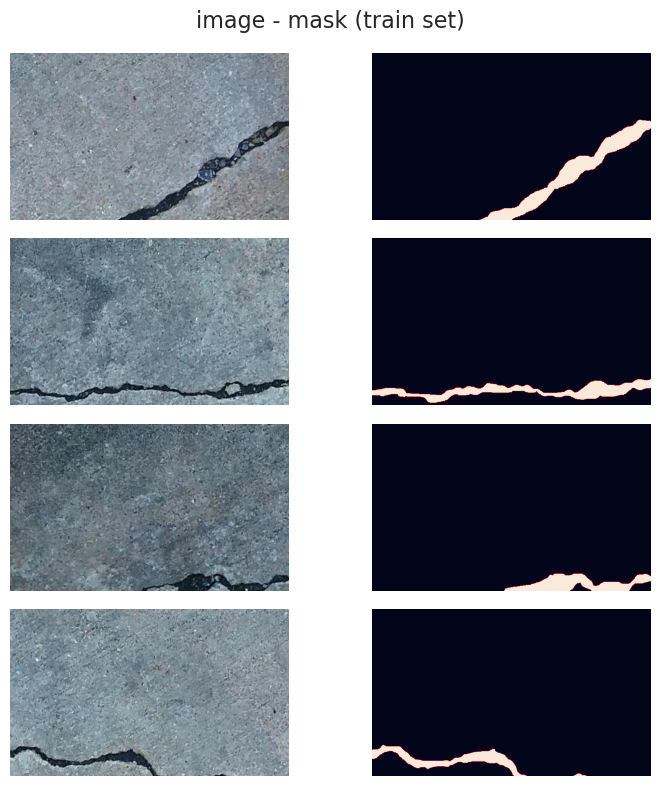

In [8]:
img_mask_iter = ((img, mask) for img, mask in test_ds)

plt.figure(figsize=(8, 8))
for i in range(0, 8, 2):
    img, mask = next(img_mask_iter)
    plt.subplot(4, 2, i + 1)
    plt.imshow(np.moveaxis(img, 0, -1))
    plt.axis("off")
    plt.subplot(4, 2, i + 2)
    plt.imshow(np.moveaxis(mask, 0, -1))
    plt.axis("off")

plt.suptitle("image - mask (train set)", fontsize=16)
plt.tight_layout()
plt.show()

# Define Model(s)


## Import a Pretrained Segmentaion model (e.g., UNET)


In [6]:
# the downloaded model are located in "~/.cache/torch/hub/checkpoints/"
# backbone_model_name = 'resnet152'
backbone_model_name = 'mobilenet_v2'

# Segmentation model is just a PyTorch nn.Module
# model = smp.FPN(
model = smp.Unet(
    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_name=backbone_model_name,
    # use `imagenet` pre-trained weights for encoder initialization
    encoder_weights="imagenet",
    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    in_channels=3,
    # model output channels (number of classes in your dataset)
    classes=hyper_params['num_classes'],
)

# load preprocessing func of the loaded model, so our data goes through the same transformation
# hint 1: it needs the input img to be in channels_last format
# hint 2: it outputs the image in channels_last format! (e.g., toch.Size[640, 360, 3])
preprocess_input = get_preprocessing_fn(
    backbone_model_name, pretrained='imagenet')

### Visualize the architecture


In [10]:
# the attribs of the model
# vars(model)

# plot the model arch
# create a dumy channels_first img (m, C, H, W)
x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
# must do a forward pass (to init weights so shapes are set)
yhat = model(x)
print(yhat.shape)

# save the architecture of the model as an image
# make_dot(yhat, params=dict(list(model.named_parameters()))).render("./outputs/model_plot/Unet_pretrained", format="png")

torch.Size([1, 1, 224, 224])


### Test the model with an img


## Load a Segmentation Model (i.e., UNET), written from scratch


In [7]:
model = UnetScratch(in_channels=3, num_classes=hyper_params["num_classes"])

# Train


In [7]:
from utils.metrics import (
    accuracy_binary_segment,
    dice_binary_segment,
    jaccard_binary_segment,
)
from utils.training import train_model
import utils.training
import utils.metrics

reload(utils.training)
reload(utils.metrics)


metrics = ("accuracy", "dice", "jaccard(IOU)")
# a dict to map metrics' name to correspoing fn
metrics_fn = {
    "accuracy": accuracy_binary_segment,
    "dice": dice_binary_segment,
    "jaccard(IOU)": jaccard_binary_segment,
}

# get the date-time (for filenames)
start_train_time = datetime.today().strftime(time_format)

# save the hyperparams to a csv file
df = pd.DataFrame(hyper_params, index=[0]).T
df.to_csv(f'outputs/hyperparams/{start_train_time}-hyperparams.csv', index=True, header=None)
display(df)

# train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    from_logits=True,
    epochs=hyper_params['epochs'],
    lr=hyper_params['lr'],
    device=device,
    metrics=metrics,
    metrics_fn=metrics_fn,
    save_model=False,
    save_checkpoint_path="./models/",
)

---------------------------------- epoch 1/10 ---------------------------------


Epoch 1: 100%|██████████| 119/119 [00:18<00:00,  6.33it/s]



loss:                 0.28
jaccard(IOU):         0.14
dice:                 0.25
accuracy:             0.94
val_loss:             0.18
val_jaccard(IOU):     0.20
val_dice:             0.33
val_accuracy:         0.97
---------------------------------- epoch 2/10 ---------------------------------


Epoch 2: 100%|██████████| 119/119 [00:19<00:00,  6.24it/s]



loss:                 0.16
jaccard(IOU):         0.23
dice:                 0.38
accuracy:             0.97
val_loss:             0.13
val_jaccard(IOU):     0.24
val_dice:             0.38
val_accuracy:         0.97
---------------------------------- epoch 3/10 ---------------------------------


Epoch 3: 100%|██████████| 119/119 [00:18<00:00,  6.28it/s]



loss:                 0.13
jaccard(IOU):         0.29
dice:                 0.45
accuracy:             0.97
val_loss:             0.11
val_jaccard(IOU):     0.30
val_dice:             0.46
val_accuracy:         0.98
---------------------------------- epoch 4/10 ---------------------------------


Epoch 4: 100%|██████████| 119/119 [00:19<00:00,  5.96it/s]



loss:                 0.11
jaccard(IOU):         0.33
dice:                 0.50
accuracy:             0.97
val_loss:             0.09
val_jaccard(IOU):     0.34
val_dice:             0.50
val_accuracy:         0.98
---------------------------------- epoch 5/10 ---------------------------------


Epoch 5: 100%|██████████| 119/119 [00:20<00:00,  5.86it/s]



loss:                 0.10
jaccard(IOU):         0.37
dice:                 0.54
accuracy:             0.97
val_loss:             0.08
val_jaccard(IOU):     0.38
val_dice:             0.54
val_accuracy:         0.98
---------------------------------- epoch 6/10 ---------------------------------


Epoch 6: 100%|██████████| 119/119 [00:20<00:00,  5.95it/s]



loss:                 0.09
jaccard(IOU):         0.40
dice:                 0.57
accuracy:             0.97
val_loss:             0.08
val_jaccard(IOU):     0.40
val_dice:             0.56
val_accuracy:         0.98
---------------------------------- epoch 7/10 ---------------------------------


Epoch 7: 100%|██████████| 119/119 [00:19<00:00,  6.17it/s]



loss:                 0.09
jaccard(IOU):         0.41
dice:                 0.58
accuracy:             0.97
val_loss:             0.08
val_jaccard(IOU):     0.42
val_dice:             0.58
val_accuracy:         0.98
---------------------------------- epoch 8/10 ---------------------------------


Epoch 8: 100%|██████████| 119/119 [00:19<00:00,  6.05it/s]



loss:                 0.09
jaccard(IOU):         0.43
dice:                 0.60
accuracy:             0.97
val_loss:             0.07
val_jaccard(IOU):     0.41
val_dice:             0.57
val_accuracy:         0.98
---------------------------------- epoch 9/10 ---------------------------------


Epoch 9: 100%|██████████| 119/119 [00:20<00:00,  5.82it/s]



loss:                 0.08
jaccard(IOU):         0.43
dice:                 0.60
accuracy:             0.97
val_loss:             0.07
val_jaccard(IOU):     0.44
val_dice:             0.60
val_accuracy:         0.98
--------------------------------- epoch 10/10 ---------------------------------


Epoch 10: 100%|██████████| 119/119 [00:19<00:00,  6.05it/s]



loss:                 0.08
jaccard(IOU):         0.45
dice:                 0.62
accuracy:             0.97
val_loss:             0.07
val_jaccard(IOU):     0.44
val_dice:             0.61
val_accuracy:         0.98


In [8]:
# Check pytorch.cuda GPU VRAM footprint
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 9         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  52993 KiB |   5639 MiB | 134201 MiB | 134149 MiB |
|       from large pool |  38504 KiB |   5594 MiB | 132534 MiB | 132497 MiB |
|       from small pool |  14489 KiB |     67 MiB |   1666 MiB |   1652 MiB |
|---------------------------------------------------------------------------|
| Active memory         |  52993 KiB |   5639 MiB | 134201 MiB | 134149 MiB |
|       from large pool |  38504 KiB |   5594 MiB | 132534 MiB |

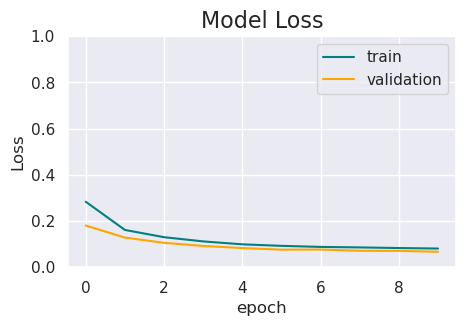

In [8]:
# print the history of evaluation metrics (during training)
# pprint(history)

# plot the metrics (both train & val)
eval_metric = "loss"
fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(history[eval_metric], color="Teal", label="train")
plt.plot(history[f"val_{eval_metric}"], color="Orange", label="validation")
plt.xlabel("epoch")
plt.ylabel(eval_metric.title())
plt.ylim((0, 1))
# plt.suptitle('Model Accuracy', fontsize=20)
plt.title(f"Model {eval_metric.title()}", fontsize=16)
plt.legend(loc="best")
plt.show()

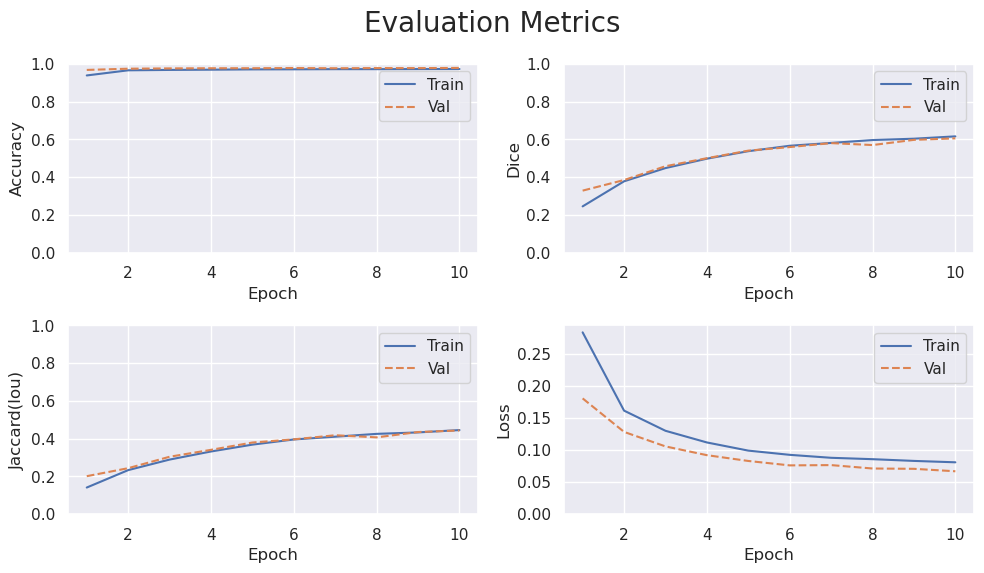

In [58]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


def plot_metrics(
    history: dict, epochs: int, metrics: list = ["loss"], auc_min: float = 0.8
) -> None:
    """
    Plot the metrics (for both the train and val)

    Parameters
    ----------
    history: dict
        the output of model.fit()
    epochs: int
        the #epochs we trained the model
    metrics: list
        a list of metrics to be plotted
    auc_min: 0.8
        as we need to zoom-in more for AUC curve, we use this to limit the range

    returns
    -------
    None
    """
    plt.figure(figsize=(10, 8))
    # take the ceiling of #metrics provided as the #rows
    plot_height = int(len(metrics) / 2) + 1

    for i, metric in enumerate(metrics):
        name = metric.replace("_", " ").title()
        plt.subplot(plot_height, 2, i + 1)
        plt.plot(range(1, epochs + 1),
                 history[metric], color=colors[0], label="Train")
        plt.plot(
            range(1, epochs + 1),
            history["val_" + metric],
            color=colors[1],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "auc":
            plt.ylim([auc_min, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()
        plt.tight_layout()


# allow seaborn to set the style only for this plot
with sns.axes_style("darkgrid", rc={"axes.grid": True}):
    plot_metrics(history, hyper_params["epochs"], metrics + ("loss",))
    plt.suptitle("Evaluation Metrics", fontsize=20)
    plt.tight_layout()
    plt.savefig(
        f"outputs/plots/{start_train_time}-train_plot.pdf", bbox_inches="tight")
    plt.show()

In [36]:
df = pd.DataFrame(history)
df.insert(loc=0, column="epoch", value=range(1, hyper_params['epochs'] + 1))
df.to_csv(f"outputs/history/{start_train_time}-train_plot.csv", index=False)
df

,epoch,loss,accuracy,dice,jaccard(IOU),val_loss,val_accuracy,val_dice,val_jaccard(IOU)
0,1,0.283593,0.938485,0.245111,0.141448,0.180631,0.967749,0.328550,0.201628
1,2,0.161566,0.965681,0.377814,0.233682,0.128412,0.974184,0.384599,0.243970
2,3,0.130139,0.967720,0.447900,0.289500,0.105778,0.975805,0.457716,0.304466
3,4,0.111944,0.969014,0.497679,0.332356,0.092118,0.976609,0.500324,0.341150
4,5,0.099217,0.970558,0.537333,0.368654,0.083079,0.976681,0.540269,0.379812
5,6,0.092635,0.970969,0.566132,0.396012,0.076196,0.977689,0.559119,0.396631
6,7,0.088015,0.971773,0.581136,0.410694,0.076627,0.976532,0.580170,0.418379
7,8,0.085867,0.971818,0.596370,0.425673,0.071329,0.977491,0.569923,0.407146
8,9,0.083164,0.972233,0.603552,0.433343,0.070837,0.977339,0.597390,0.435377
9,10,0.080987,0.972592,0.615886,0.445824,0.067002,0.978393,0.605361,0.443720


# Test (MOVE THIS TO ANOTHER NOTEBOOK AND USE THE SAVED CHECKPOINT MODEL)


In [ ]:
# use the model on test set

In [18]:
def evaluate_model(model, dataset, metrics) -> dict:
    # calc the yhat
    yhat = train_model(model.cpu(), dataset, from_logits=True)

    # calc metrics
    metrics = 0

    # convert metrics to a dict (e.g., {'accuracy': int, 'dice': int, etc.})

    return metrics


a = pd.Series(evaluate_model(model, train_loader,
              ('loss',)+metrics), name='Train')
b = pd.Series(evaluate_model(model, val_loader, ('loss',)+metrics), name='Val')
c = pd.Series(evaluate_model(model, test_loader,
              ('loss',)+metrics), name='Test')

df = pd.concat([a, b, c], axis=1)
print('Model evaluation on diff sets')
display(df)

---------------------------------- epoch 1/5 ----------------------------------
 lr_rate reduced to 0.001


100%|██████████| 2/2 [00:00<00:00,  4.23it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 7.92 GiB total capacity; 6.13 GiB already allocated; 46.00 MiB free; 6.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Inference (MOVE THIS TO ANOTHER NOTEBOOK AND USE THE SAVED CHECKPOINT MODEL)

> for single images


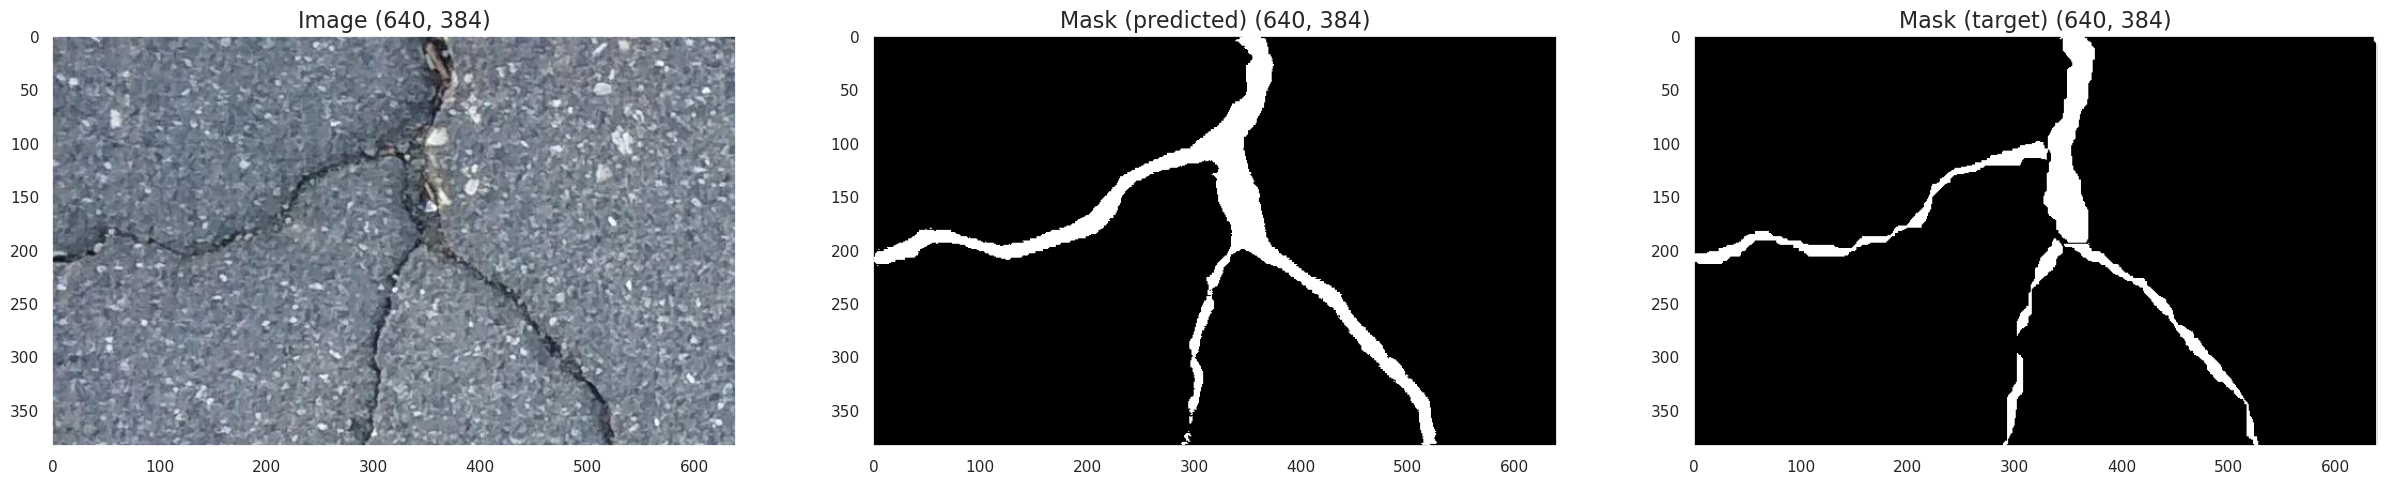

In [55]:
# Lowres images
# img 1 (from traincrop)
# img_filename =  '20160222_081011_1_721.jpg'
# mask_filename = '20160222_081011_1_721_mask.png'
# img 2 (from testcrop)
img_filename = '20160307_164226_1_1.jpg'
mask_filename = '20160307_164226_1_1_mask.png'
# Highres images (from train)
# img_filename =  '20160222_081102.jpg'
# mask_filename = '20160222_081102_mask.png'
img_addr = os.path.join('images', img_filename)
mask_addr = os.path.join('images', mask_filename)

img = Image.open(img_addr).resize((hyper_params['image_width'], hyper_params['image_height']))
mask = Image.open(mask_addr).resize((hyper_params['image_width'], hyper_params['image_height']))

# normalize [-1, 1] the PIL image as a torch.Tensor
img_tensor = (TF.functional.pil_to_tensor(img) / 127.5 - 1).to(device)

yhat = model(img_tensor.unsqueeze(dim=0))
yhat_c_last = yhat[0].moveaxis(0, -1).detach().cpu().numpy()
thresh = 0.5
mask_batch = np.where(yhat_c_last >= thresh, 255, 0)

fig, axes = plt.subplots(1, 3, figsize=(30, 10))
axes[0].imshow(img)
axes[0].set_title(f'Image {img.size}', fontsize=16)
axes[1].imshow(mask_batch, cmap='gray')
axes[1].set_title(
    f'Mask (predicted) {mask_batch.shape[:2][::-1]}', fontsize=16)
axes[2].imshow(mask, cmap='gray')
axes[2].set_title(f'Mask (target) {mask.size}', fontsize=16)
# plt.savefig(f'outputs/Inferences/{start_train_time}-{img_filename}.png', bbox_inches='tight'))
plt.savefig(f'outputs/Inferences/-{img_filename}.png', bbox_inches='tight')
plt.show()

In [37]:
from utils.visualization import torch_tensor_for_plt, plot_segmentation_inference
from utils.inferencing import inference_segmentation, img_to_inference_tensor
import utils.inferencing
import utils.visualization
reload(utils.inferencing)
reload(utils.visualization)


img_filename = '20160222_081011_1_721.jpg'
mask_filename = '20160222_081011_1_721_mask.jpg'
img_addr = os.path.join('images', img_filename)
mask_addr = os.path.join('images', mask_filename)

# only for one image, if multiple use utils.dataset
test_img_batch = img_to_inference_tensor(
    img_addr, size=(hyper_params['image_height'], hyper_params['image_width']))
test_mask_batch = img_to_inference_tensor(
    mask_addr, size=(hyper_params['image_height'], hyper_params['image_width']))

# make an inference
yhat_mask = inference_segmentation(
    test_img_batch, model=model, normalize=True, device=device)

# make torch.Tensors ready for pyplot
test_img_batch = torch_tensor_for_plt(test_img_batch)
test_mask_batch = torch_tensor_for_plt(test_mask_batch)
yhat_mask = torch_tensor_for_plt(yhat_mask)

# plot the inference
plot_segmentation_inference(test_img_batch, test_mask_batch, yhat_mask)

FileNotFoundError: [Errno 2] No such file or directory: 'images/20160222_081011_1_721_mask.jpg'

#
